In [1]:
import numpy
import torch
import torch.nn as nn
from collections import OrderedDict
import os
import sys
import warnings
from torch.utils.data import DataLoader
import argparse
import time
import copy
import math
import torchvision.utils as vision_utils
import json
import numpy as np
from torch.distributions import bernoulli
from scipy import linalg
import torchvision.datasets as _datasets
import torchvision.transforms as _transforms
import matplotlib.pyplot as plt
import shutil

from data import Binarize, Smooth, load_mnist, get_sampler
from evals import compute_mu_sigma_pretrained_model, calculate_frechet_distance, _calculate_metrics, get_metrics
from losses import get_disciminator_loss, get_generator_loss
from model import DiscriminatorCNN28, GeneratorCNN28, MLP_mnist, pretrained_mnist_model
from trainer import train, train_torch_SGD
from updates import Lookahead, update_avg_gen, update_ema_gen
from utils import save_models, get_plot_func, get_num_params

In [2]:
a = 1

In [3]:
_NOISE_DIM = 8
_H_FILTERS = 4

In [4]:
G = GeneratorCNN28(noise_dim=_NOISE_DIM, h_filters=_H_FILTERS, out_tanh=True)
D = DiscriminatorCNN28(h_filters=_H_FILTERS, spectral_norm=False, img_size=28)

In [5]:
get_num_params(G)

12672

In [6]:
get_num_params(D)

2768

Loading trained model from ./drive/My Drive/Data/models/mnist.pth
Iter 0: Mean proba from D(G(z)): 0.5311 +/- 0.0816


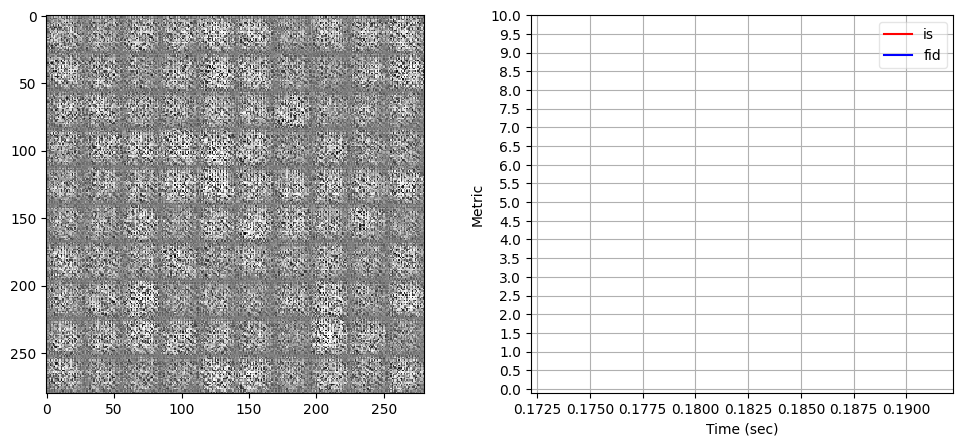

Iter 5000: Mean proba from D(G(z)): 0.3888 +/- 0.0995


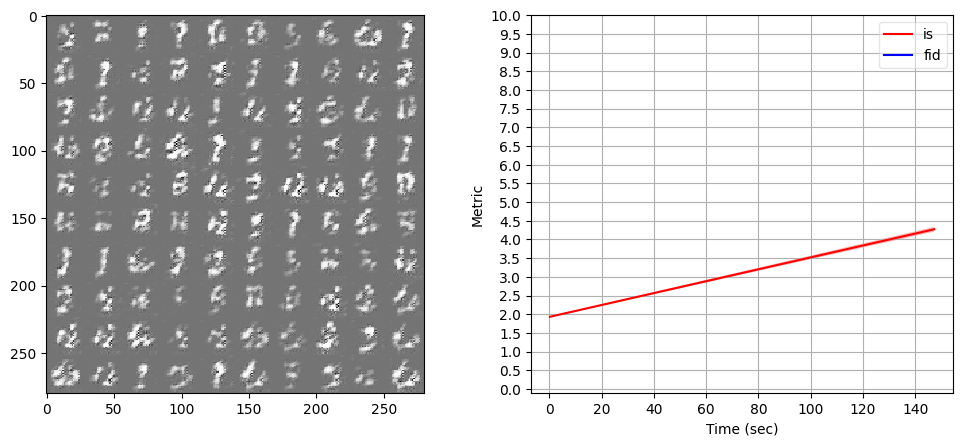

Iter 10000: Mean proba from D(G(z)): 0.1674 +/- 0.0886


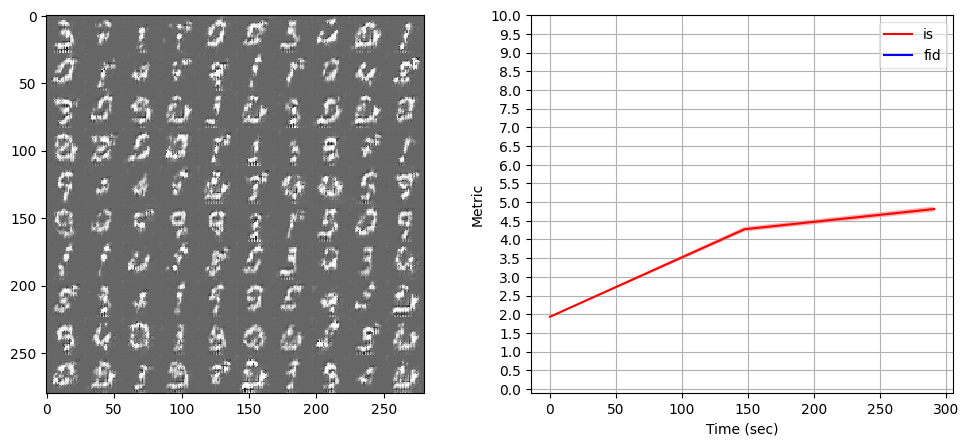

Iter 15000: Mean proba from D(G(z)): 0.1288 +/- 0.0692


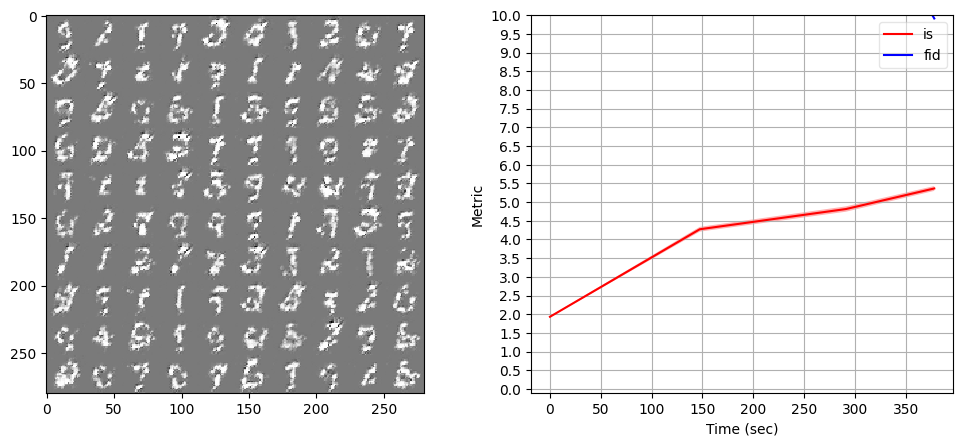

Iter 20000: Mean proba from D(G(z)): 0.5252 +/- 0.1617


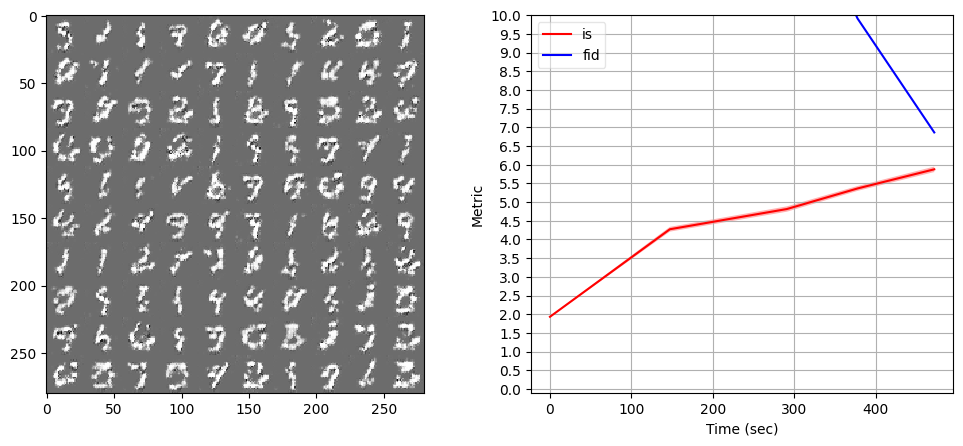

Iter 25000: Mean proba from D(G(z)): 0.3768 +/- 0.1255


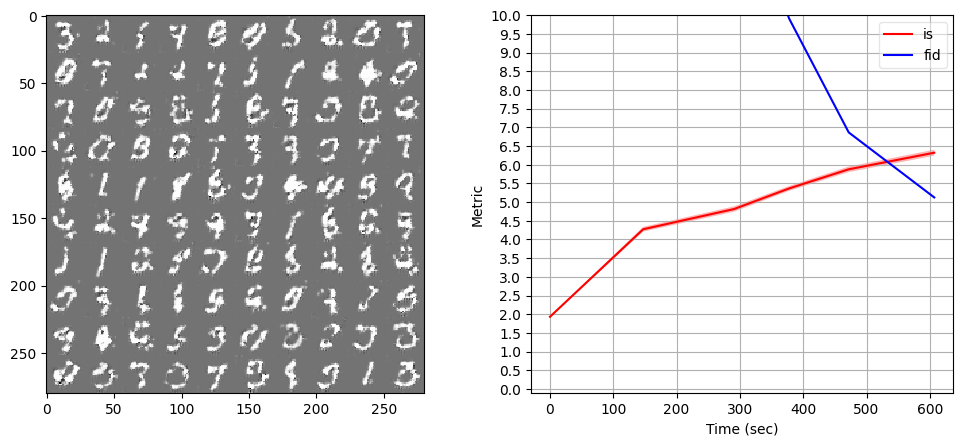

Iter 30000: Mean proba from D(G(z)): 0.5006 +/- 0.1483


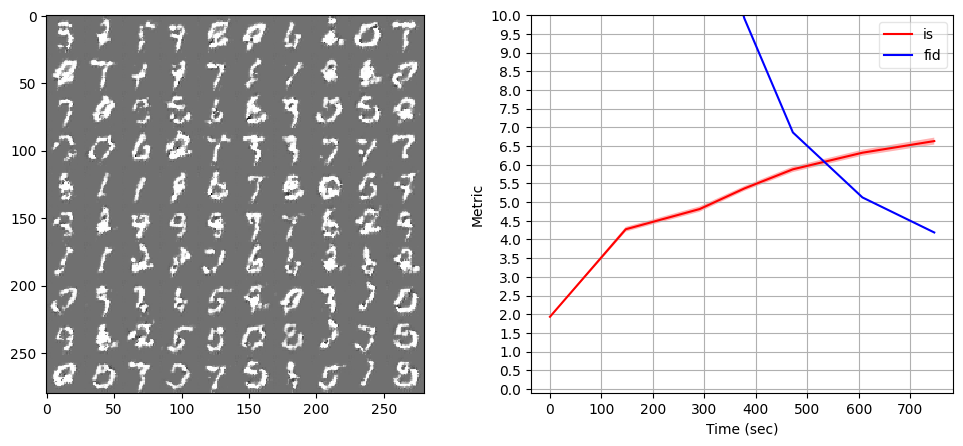

Iter 35000: Mean proba from D(G(z)): 0.2944 +/- 0.1277


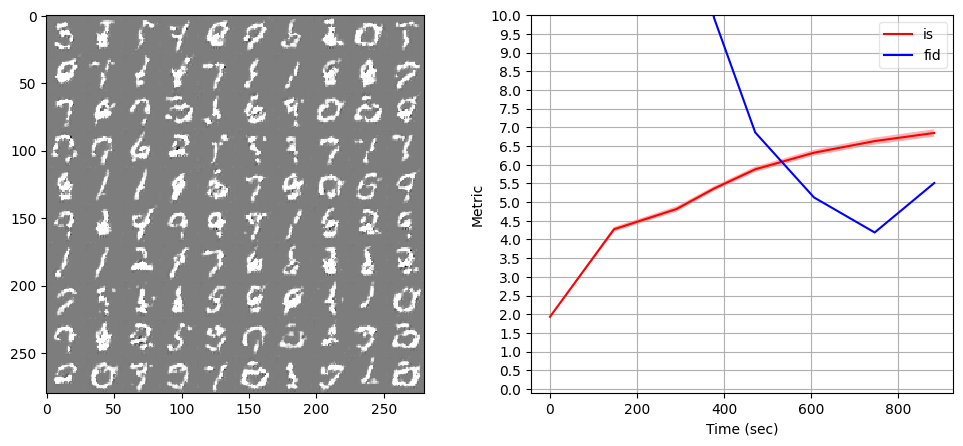

Iter 40000: Mean proba from D(G(z)): 0.5419 +/- 0.1351


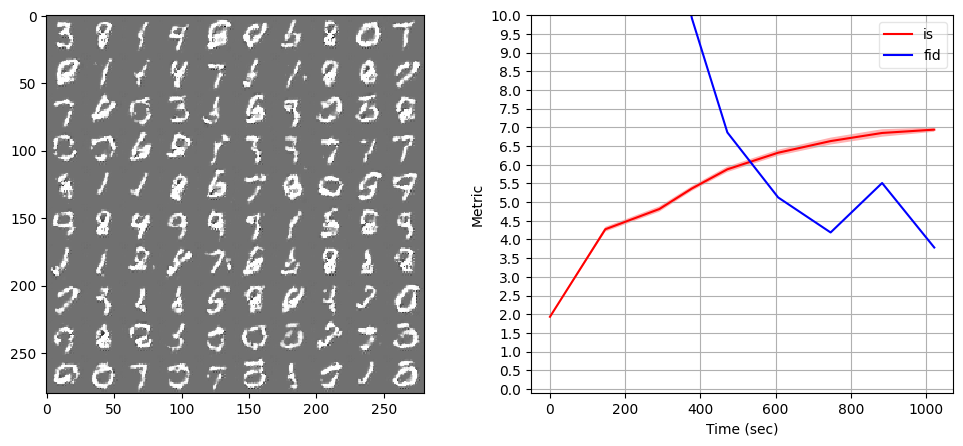

Iter 45000: Mean proba from D(G(z)): 0.1856 +/- 0.1137


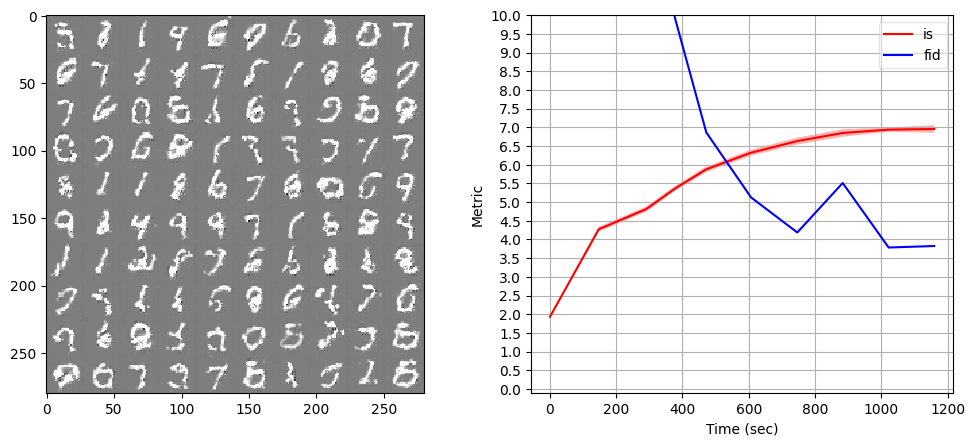

Iter 50000: Mean proba from D(G(z)): 0.1090 +/- 0.0730


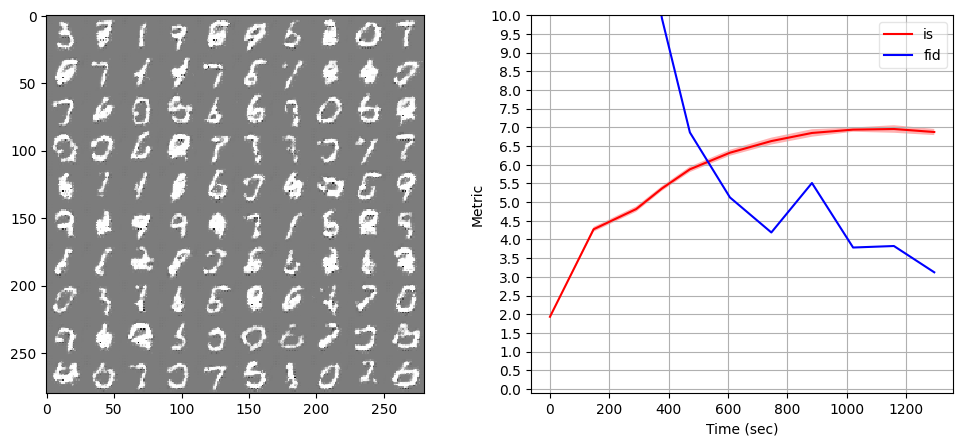

Iter 55000: Mean proba from D(G(z)): 0.2531 +/- 0.1145


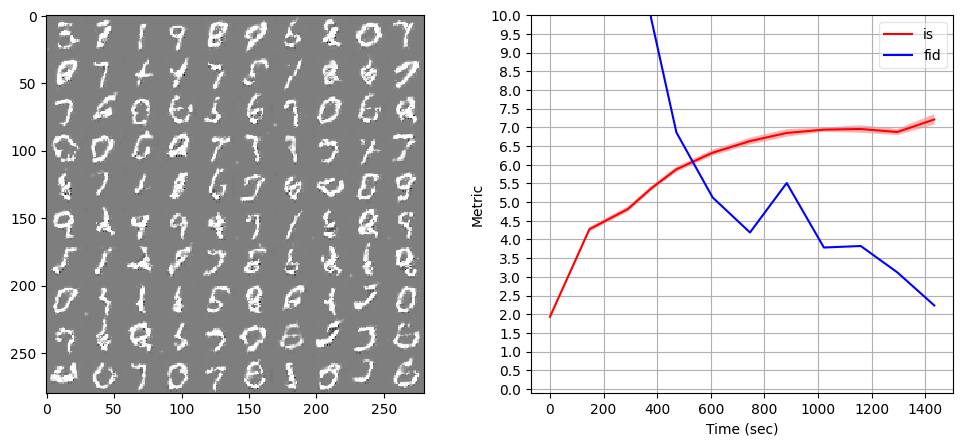

Iter 60000: Mean proba from D(G(z)): 0.1727 +/- 0.0910


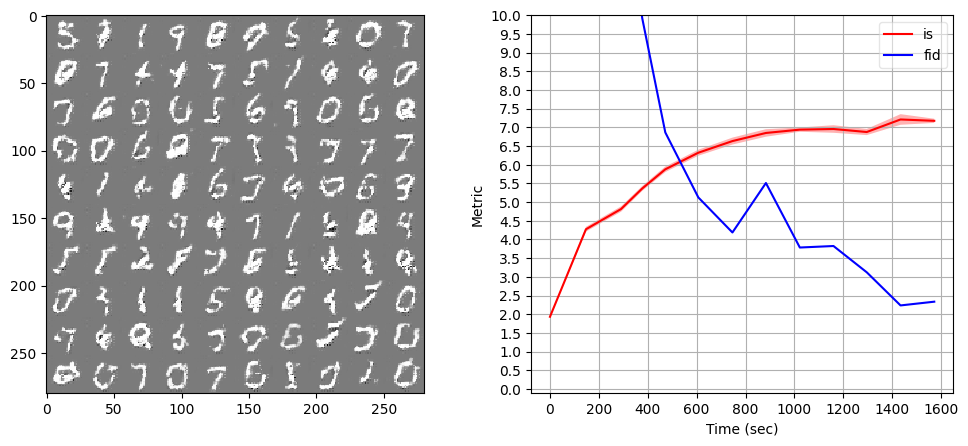

Iter 65000: Mean proba from D(G(z)): 0.5857 +/- 0.1739


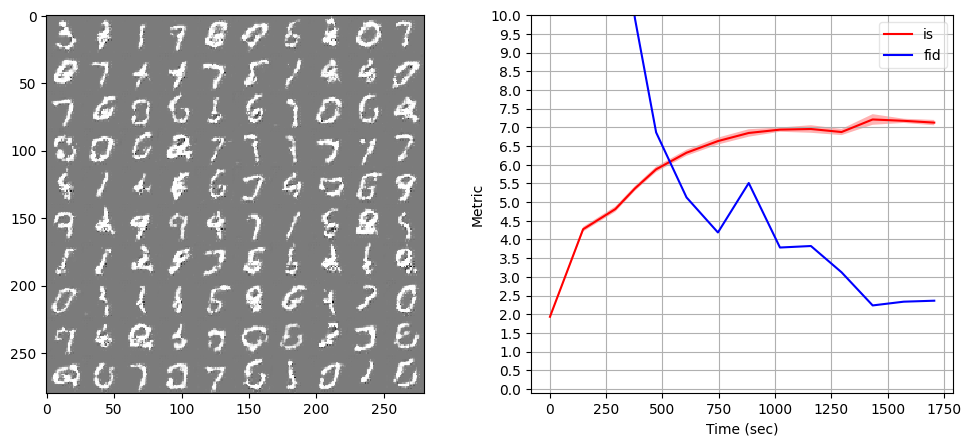

Iter 70000: Mean proba from D(G(z)): 0.2712 +/- 0.1113


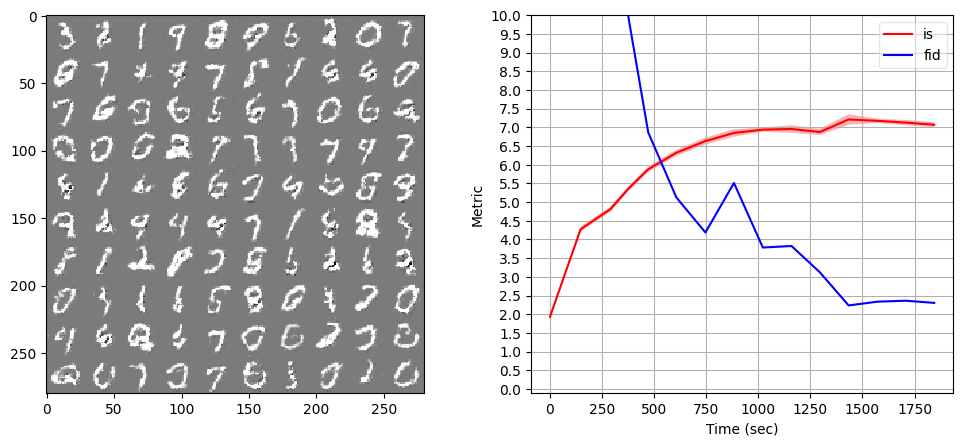

Iter 75000: Mean proba from D(G(z)): 0.0982 +/- 0.0714


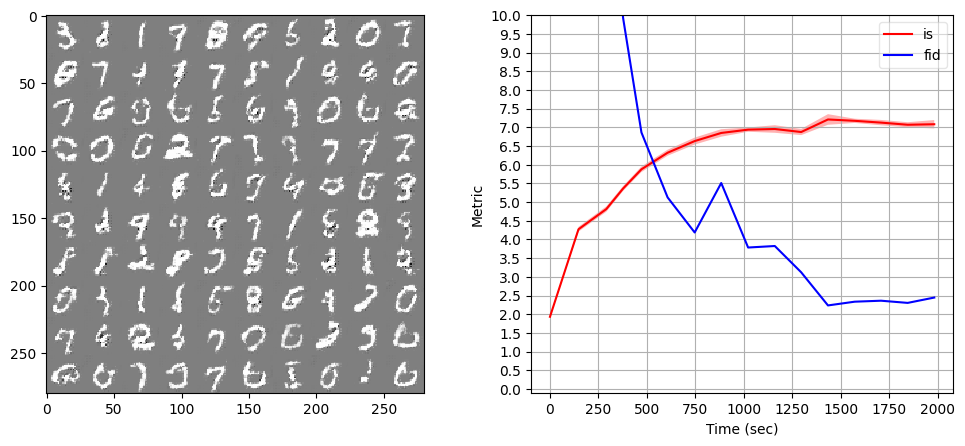

Iter 80000: Mean proba from D(G(z)): 0.2061 +/- 0.1244


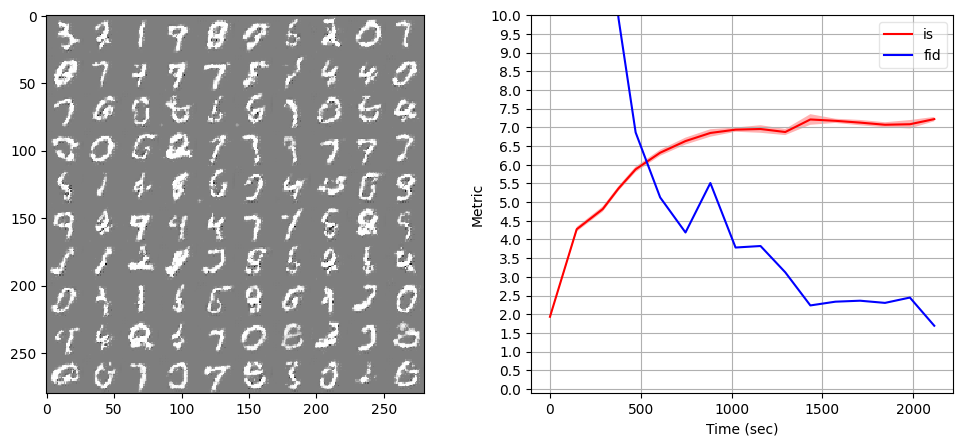

Iter 85000: Mean proba from D(G(z)): 0.2995 +/- 0.1434


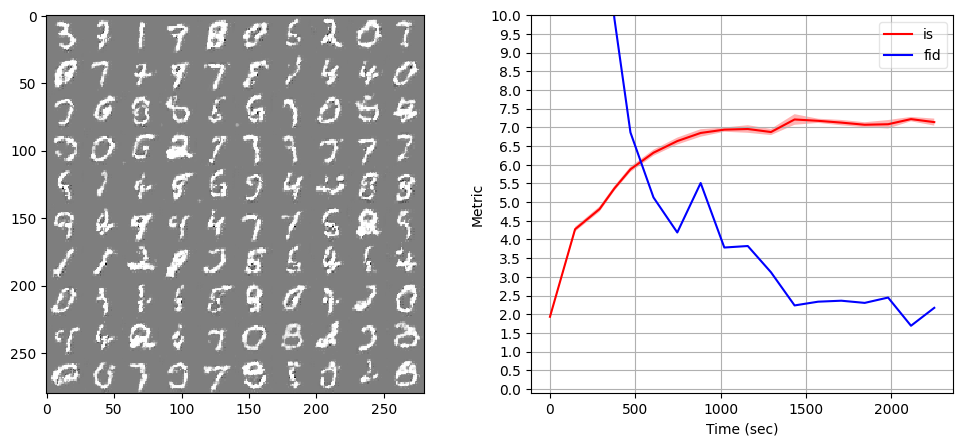

Iter 90000: Mean proba from D(G(z)): 0.2316 +/- 0.1122


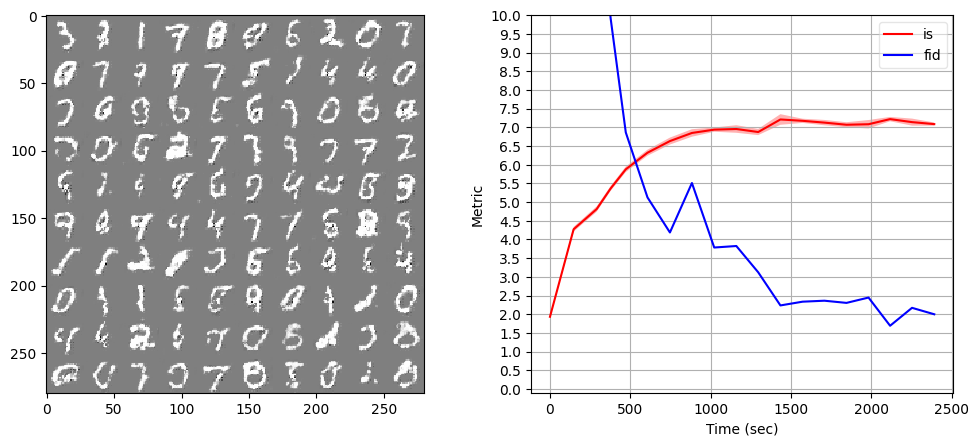

Iter 95000: Mean proba from D(G(z)): 0.2117 +/- 0.1155


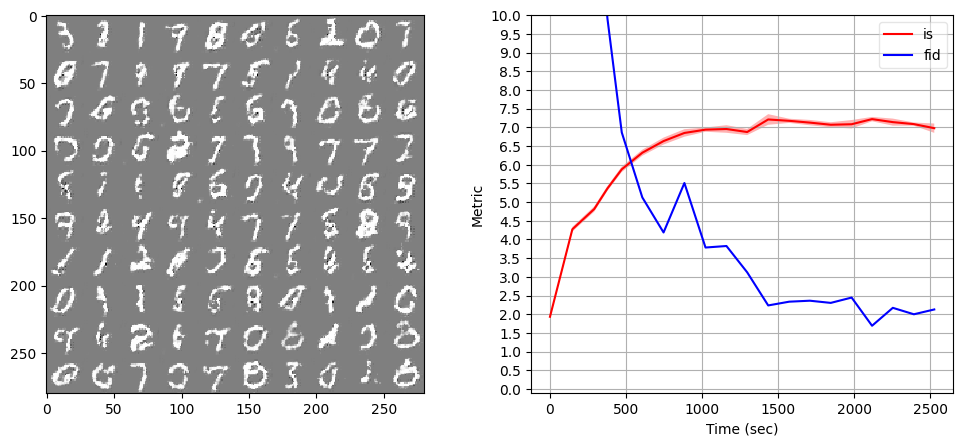

Iter 99999: Mean proba from D(G(z)): 0.4061 +/- 0.1416


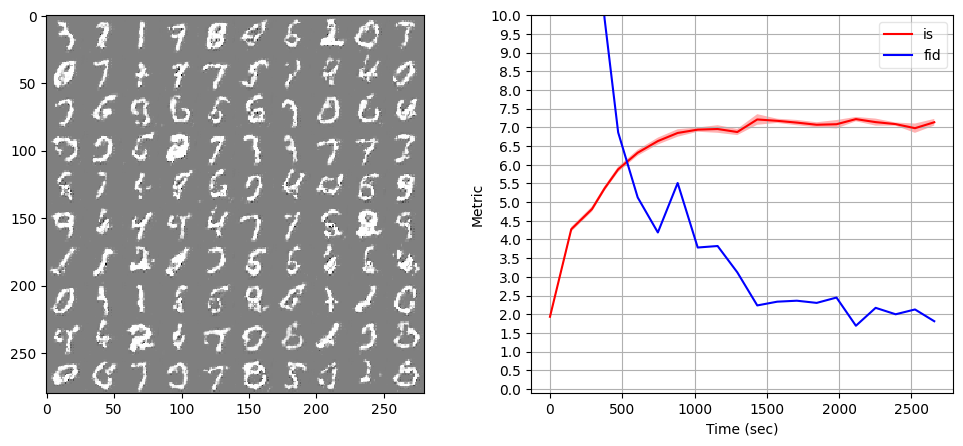

In [8]:
args = dict(iterations = 100000,
            batch_size = 128,
            lrD = 0.001,
            lrG = 0.001,
            beta1 = 0.05,
            extragrad = False,
            eval_every = 5000,
            lookahead = False,
            eval_avg = False,
            lookahead_k = 1000,
            n_workers = 5,
            device = 'cuda',
            grad_max_norm = None)


for k in range(1,1+1):
  exp_key = f"iter{args['iterations']}_bs{args['batch_size']}_lrD{args['lrD']}" + \
            f"_lrG{args['lrG']}" + \
            f"_ee{args['eval_every']}"
  out_dir = f"/home/mila/t/tianyu.zhang/GAN_LOLA/drive/My Drive/results/final/{exp_key}/{k}/"

  shutil.rmtree(out_dir, ignore_errors=True)
  if not os.path.exists(out_dir):
    os.makedirs(out_dir)

  with open(os.path.join(out_dir, 'args.json'), 'w') as fs:
    json.dump(args, fs)

  dataset = load_mnist(_data_root='datasets', binarized=False)

  plot_func = get_plot_func(out_dir=out_dir, 
                            img_size=dataset[0][0].size(),
                            num_samples_eval=10000)

  G = GeneratorCNN28(noise_dim=_NOISE_DIM, h_filters=_H_FILTERS, out_tanh=True)
  D = DiscriminatorCNN28(h_filters=_H_FILTERS, spectral_norm=False, img_size=28)

  train_torch_SGD(G, D, dataset, 
        iterations=args['iterations'], 
        batch_size=args['batch_size'], 
        lookahead=args['lookahead'],
        lookahead_k=args['lookahead_k'],
        eval_avg=args['eval_avg'],
        lrD=args['lrD'], 
        lrG=args['lrG'], 
        beta1=args['beta1'], 
        extragrad=args['extragrad'],
        eval_every=args['eval_every'], 
        n_workers=args['n_workers'], 
        device=torch.device(args['device']), 
        grad_max_norm=args['grad_max_norm'], 
        plot_func=plot_func,
        out_dir=out_dir)

Loading trained model from ./drive/My Drive/Data/models/mnist.pth
Iter 0: Mean proba from D(G(z)): 0.5048 +/- 0.0801


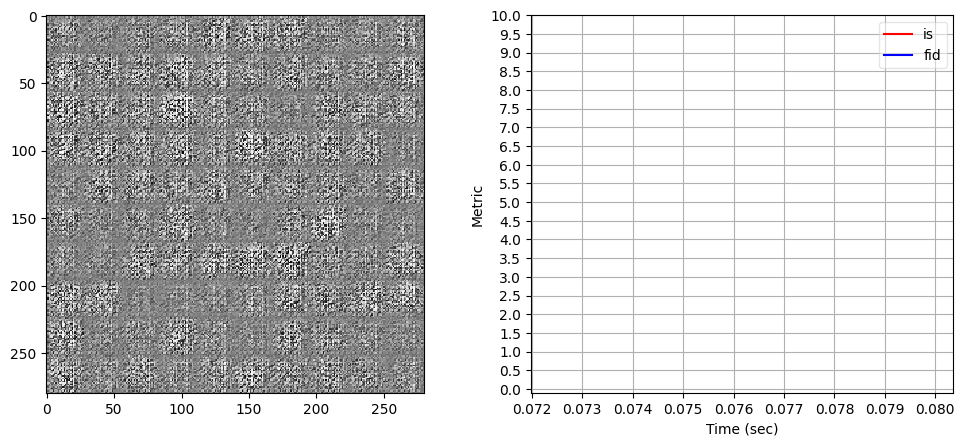

In [ ]:
args = dict(iterations = 100000,
            batch_size = 128,
            lrD = 0.0001,
            lrG = 0.0001,
            beta1 = 0.05,
            extragrad = False,
            eval_every = 5000,
            lookahead = False,
            eval_avg = False,
            lookahead_k = 1000,
            n_workers = 5,
            device = 'cuda',
            grad_max_norm = None)


for k in range(1,1+1):
  exp_key = f"iter{args['iterations']}_bs{args['batch_size']}_lrD{args['lrD']}" + \
            f"_lrG{args['lrG']}" + \
            f"_ee{args['eval_every']}"
  out_dir = f"/home/mila/t/tianyu.zhang/GAN_LOLA/drive/My Drive/results/final/{exp_key}/{k}/"

  shutil.rmtree(out_dir, ignore_errors=True)
  if not os.path.exists(out_dir):
    os.makedirs(out_dir)

  with open(os.path.join(out_dir, 'args.json'), 'w') as fs:
    json.dump(args, fs)

  dataset = load_mnist(_data_root='datasets', binarized=False)

  plot_func = get_plot_func(out_dir=out_dir, 
                            img_size=dataset[0][0].size(),
                            num_samples_eval=10000)

  G = GeneratorCNN28(noise_dim=_NOISE_DIM, h_filters=_H_FILTERS, out_tanh=True)
  D = DiscriminatorCNN28(h_filters=_H_FILTERS, spectral_norm=False, img_size=28)

  train_torch_SGD(G, D, dataset, 
        iterations=args['iterations'], 
        batch_size=args['batch_size'], 
        lookahead=args['lookahead'],
        lookahead_k=args['lookahead_k'],
        eval_avg=args['eval_avg'],
        lrD=args['lrD'], 
        lrG=args['lrG'], 
        beta1=args['beta1'], 
        extragrad=args['extragrad'],
        eval_every=args['eval_every'], 
        n_workers=args['n_workers'], 
        device=torch.device(args['device']), 
        grad_max_norm=args['grad_max_norm'], 
        plot_func=plot_func,
        out_dir=out_dir)